# Semantic Segmentation

In [1]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Program Files\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


In [2]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name(vgg_input_tensor_name)
    keep_prob   = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    layer3_out  = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    layer4_out  = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    layer7_out  = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return image_input, keep_prob, layer3_out, layer4_out, layer7_out

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [3]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # To build the decoder portion of FCN-8, we’ll upsample the input to the original image size.  
    # The shape of the tensor after the final convolutional transpose layer will be 4-dimensional:
    # (batch_size, original_height, original_width, num_classes).
    layer7_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, kernel_size=1, strides=(1,1),
                                  padding='same',
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))       # 1x1 conv for layer 7
    
    layer7_us = tf.layers.conv2d_transpose(layer7_1x1, num_classes, kernel_size=4, strides=(2,2),
                                           padding='same',
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))       # upsample

    layer4_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, kernel_size=1, strides=(1,1),
                                   padding='same',
                                   kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))      # 1x1 conv for layer 4
    
    add_74 = tf.add(layer7_us, layer4_1x1)                                              # add layer 4 with the upsamp of layer 7
    
    add_74_us = tf.layers.conv2d_transpose(add_74, num_classes,  kernel_size=4, strides=(2,2),
                                           padding='same',
                                           kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))           # upsample
    
    layer3_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, kernel_size=1, strides=(1,1),
                                  padding='same',
                                  kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))       # 1x1 conv for layer 3
    
    add_743 = tf.add(add_74_us, layer3_1x1)                                             # add layer 3 with the upsamp of layer add_74
    
    add_743_us = tf.layers.conv2d_transpose(add_743, num_classes, kernel_size=16, strides=(8,8),
                                            padding='same',
                                            kernel_regularizer=tf.contrib.layers.l2_regularizer(1e-3))        # upsample
    
    return add_743_us
    
tests.test_layers(layers)

Tests Passed


In [4]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))

    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss

tests.test_optimize(optimize)

Tests Passed


In [5]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    log = open("output.log", 'w', buffering=1)
    log.write("Trainning...\n")
    rate = 0.0005
    gear_shift = 10

    for ei in range(epochs):
        k=0
        if (ei>=gear_shift):
            rate = 0.0001
            if (ei==gear_shift):
                print("Gear Shift of the learning_rate")
                log.write("Gear Shift of the learning_rate")
        
        for images, labels in get_batches_fn(batch_size):
            sess.run(train_op, feed_dict={input_image: images, correct_label: labels, keep_prob:0.75, learning_rate:rate})
            
            if (k%5) == 0:
                loss = sess.run(cross_entropy_loss, feed_dict={input_image: images, correct_label: labels, keep_prob: 1.0})
                print("Epoch {}/{} ; iteration={} ; Training Loss: {:.3f}".format(ei+1, epochs, k, loss))
                log.write("Epoch {}/{} ; iteration={} ; Training Loss: {:.3f}\n".format(ei+1, epochs, k, loss))
            k += 1
    
    log.close()
    
tests.test_train_nn(train_nn)

INFO:tensorflow:Restoring parameters from b'./data\\vgg\\variables\\variables'


In [ ]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/
    
    # Hyper params
    epochs = 15
    batch_size = 1
    
    # placeholder
    correct_label = tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], num_classes])
    learning_rate = tf.placeholder(tf.float32)
    keep_prob = tf.placeholder(tf.float32)

    # my gear has insuffice memory
    #config = tf.ConfigProto()
    #config.gpu_options.allocator_type ='BFC'
    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function
        image_input, keep_prob, layer3_out, layer4_out, layer7_out = load_vgg(sess, vgg_path)
        output = layers(layer3_out, layer4_out, layer7_out, num_classes)
        logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, num_classes)
        
        
        # TODO: Train NN using the train_nn function
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input,
             correct_label, keep_prob, learning_rate)

        # TODO: Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

        # OPTIONAL: Apply the trained model to a video

run()

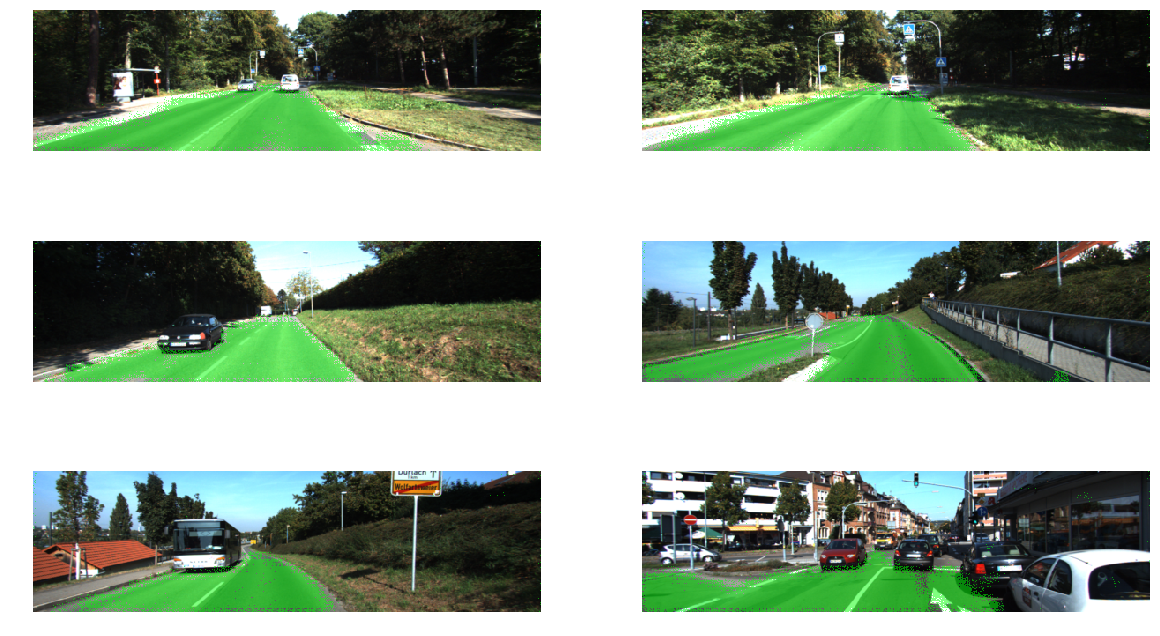

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

new_images = ["um_000007.png", "um_000008.png", "um_000019.png", "um_000029.png", "um_000032.png", "um_000061.png"]
index = 1
plt.figure(figsize=(20,12))
for img_name in new_images:
    img_data = mpimg.imread("runs/1504591801.8114545/" + img_name)
    p = plt.subplot(3, 2, index)
    p.axis("off")
    plt.imshow(img_data)
    p.axis("off")
    index += 1
plt.show()
